# Japan Equity Multi-Factor Strategy: Integrating Quality, Value, and Earnings Quality
**An Empirical Implementation based on Yartseva (2025) "The Alchemy of Multibagger Stocks"**

*   **Author:** Quantamental Researcher (CPA)
*   **Date:** 2026-01-28
*   **Reference Paper:** Yartseva, A. (2025). *The Alchemy of Multibagger Stocks*. CAFE Working Paper No.33. [Available at BCU Open Access](https://www.open-access.bcu.ac.uk/16180/)

## 1. Executive Summary
本プロジェクトは、Yartseva (2025) が提唱した「マルチバガー（10倍株）形成要因」に関する最新の実証研究を日本市場（JPX）に適応させたクオンツメンタル戦略の実装研究です。

論文で示された **"Twin Engines" (Earnings Growth + Valuation Expansion)** の概念に加え、公認会計士（CPA）の専門的知見に基づく **「利益の質（Earnings Quality）の定量評価」** を独自に統合しました。
**「会計上の見積もりの歪み（Accounting Estimate Bias）」** を調整することで、ダウンサイドリスク（利益の質の低下や将来の減損リスク）を軽減しつつ、高いポテンシャルを持つ銘柄を発掘します。

### Strategy Edge: "Openness & Reproducibility"
一般的なクオンツモデルがブラックボックスな加工済みデータ（Standardized Data）に依存しがちなのに対し、本モデルは **「検証可能性（Reproducibility）」** を最優先する設計思想に基づいています。

1.  **Data Source Strategy (Open & Reproducible):**
    * 高額なプロプライエタリ（有料）データベースには依存せず、**日本の法定開示システム（EDINET）から一次情報を直接取得するパイプライン**を構築しました。
    * これにより、データ取得から前処理までの全工程をコードとして公開・透明化し、誰もがゼロから同じ結果を再現できる環境を整備しています。
2.  **Risk Management (Modified Sloan Ratio):**
    * 日本基準特有の特別損益項目を考慮し、営業利益ではなく当期純利益を用いた修正スローンレシオを採用。「利益の嵩上げ」を検知し、粉飾決算の予兆がある銘柄を事前にスクリーニングします。

### Disclaimer & Critical Limitations (Must Read)
本モデルはプロトタイプであり、以下の重大な制約が存在します。

*   **Survivorship Bias (生存バイアス):** 本検証は検証時点（Current）の上場銘柄を母集団として過去へ遡及しているため、過去の倒産・上場廃止銘柄が含まれていません。したがって、本検証の累積リターンは **「理論上の上限値（Theoretical Ceiling）」** であり、実運用においてはこれより劣後する可能性が極めて高いです。
*   **Data Coverage Constraint:** EDINET APIの仕様等により、特に2016年〜2017年のデータにおいて**約11%の取得漏れ**が発生しています。これは経営不振による決算遅延企業等が含まれる可能性があり、データの欠損自体がバイアス（Systematic Bias）を持っている可能性があります。また、無料APIを使用しているため、株式分割の完全な遡及調整や厳密な時価総額計算には一部制約があります。
*   **Market Impact:** バックテストは取引コスト（手数料・スリッページ）を考慮していません。推奨銘柄には流動性の低い小型株が含まれるため、実運用ではマーケットインパクトによりパフォーマンスが低下します。

---
### System Architecture

<!-- 
【Note regarding image embedding】
GitHubのNotebook Viewer上でのレンダリング不具合（相対パスやIssueリンクが正しく解決されない問題）を回避し、あらゆる環境下での表示を確実に保証するため、Base64エンコードによる直接埋め込みを採用しています。
-->

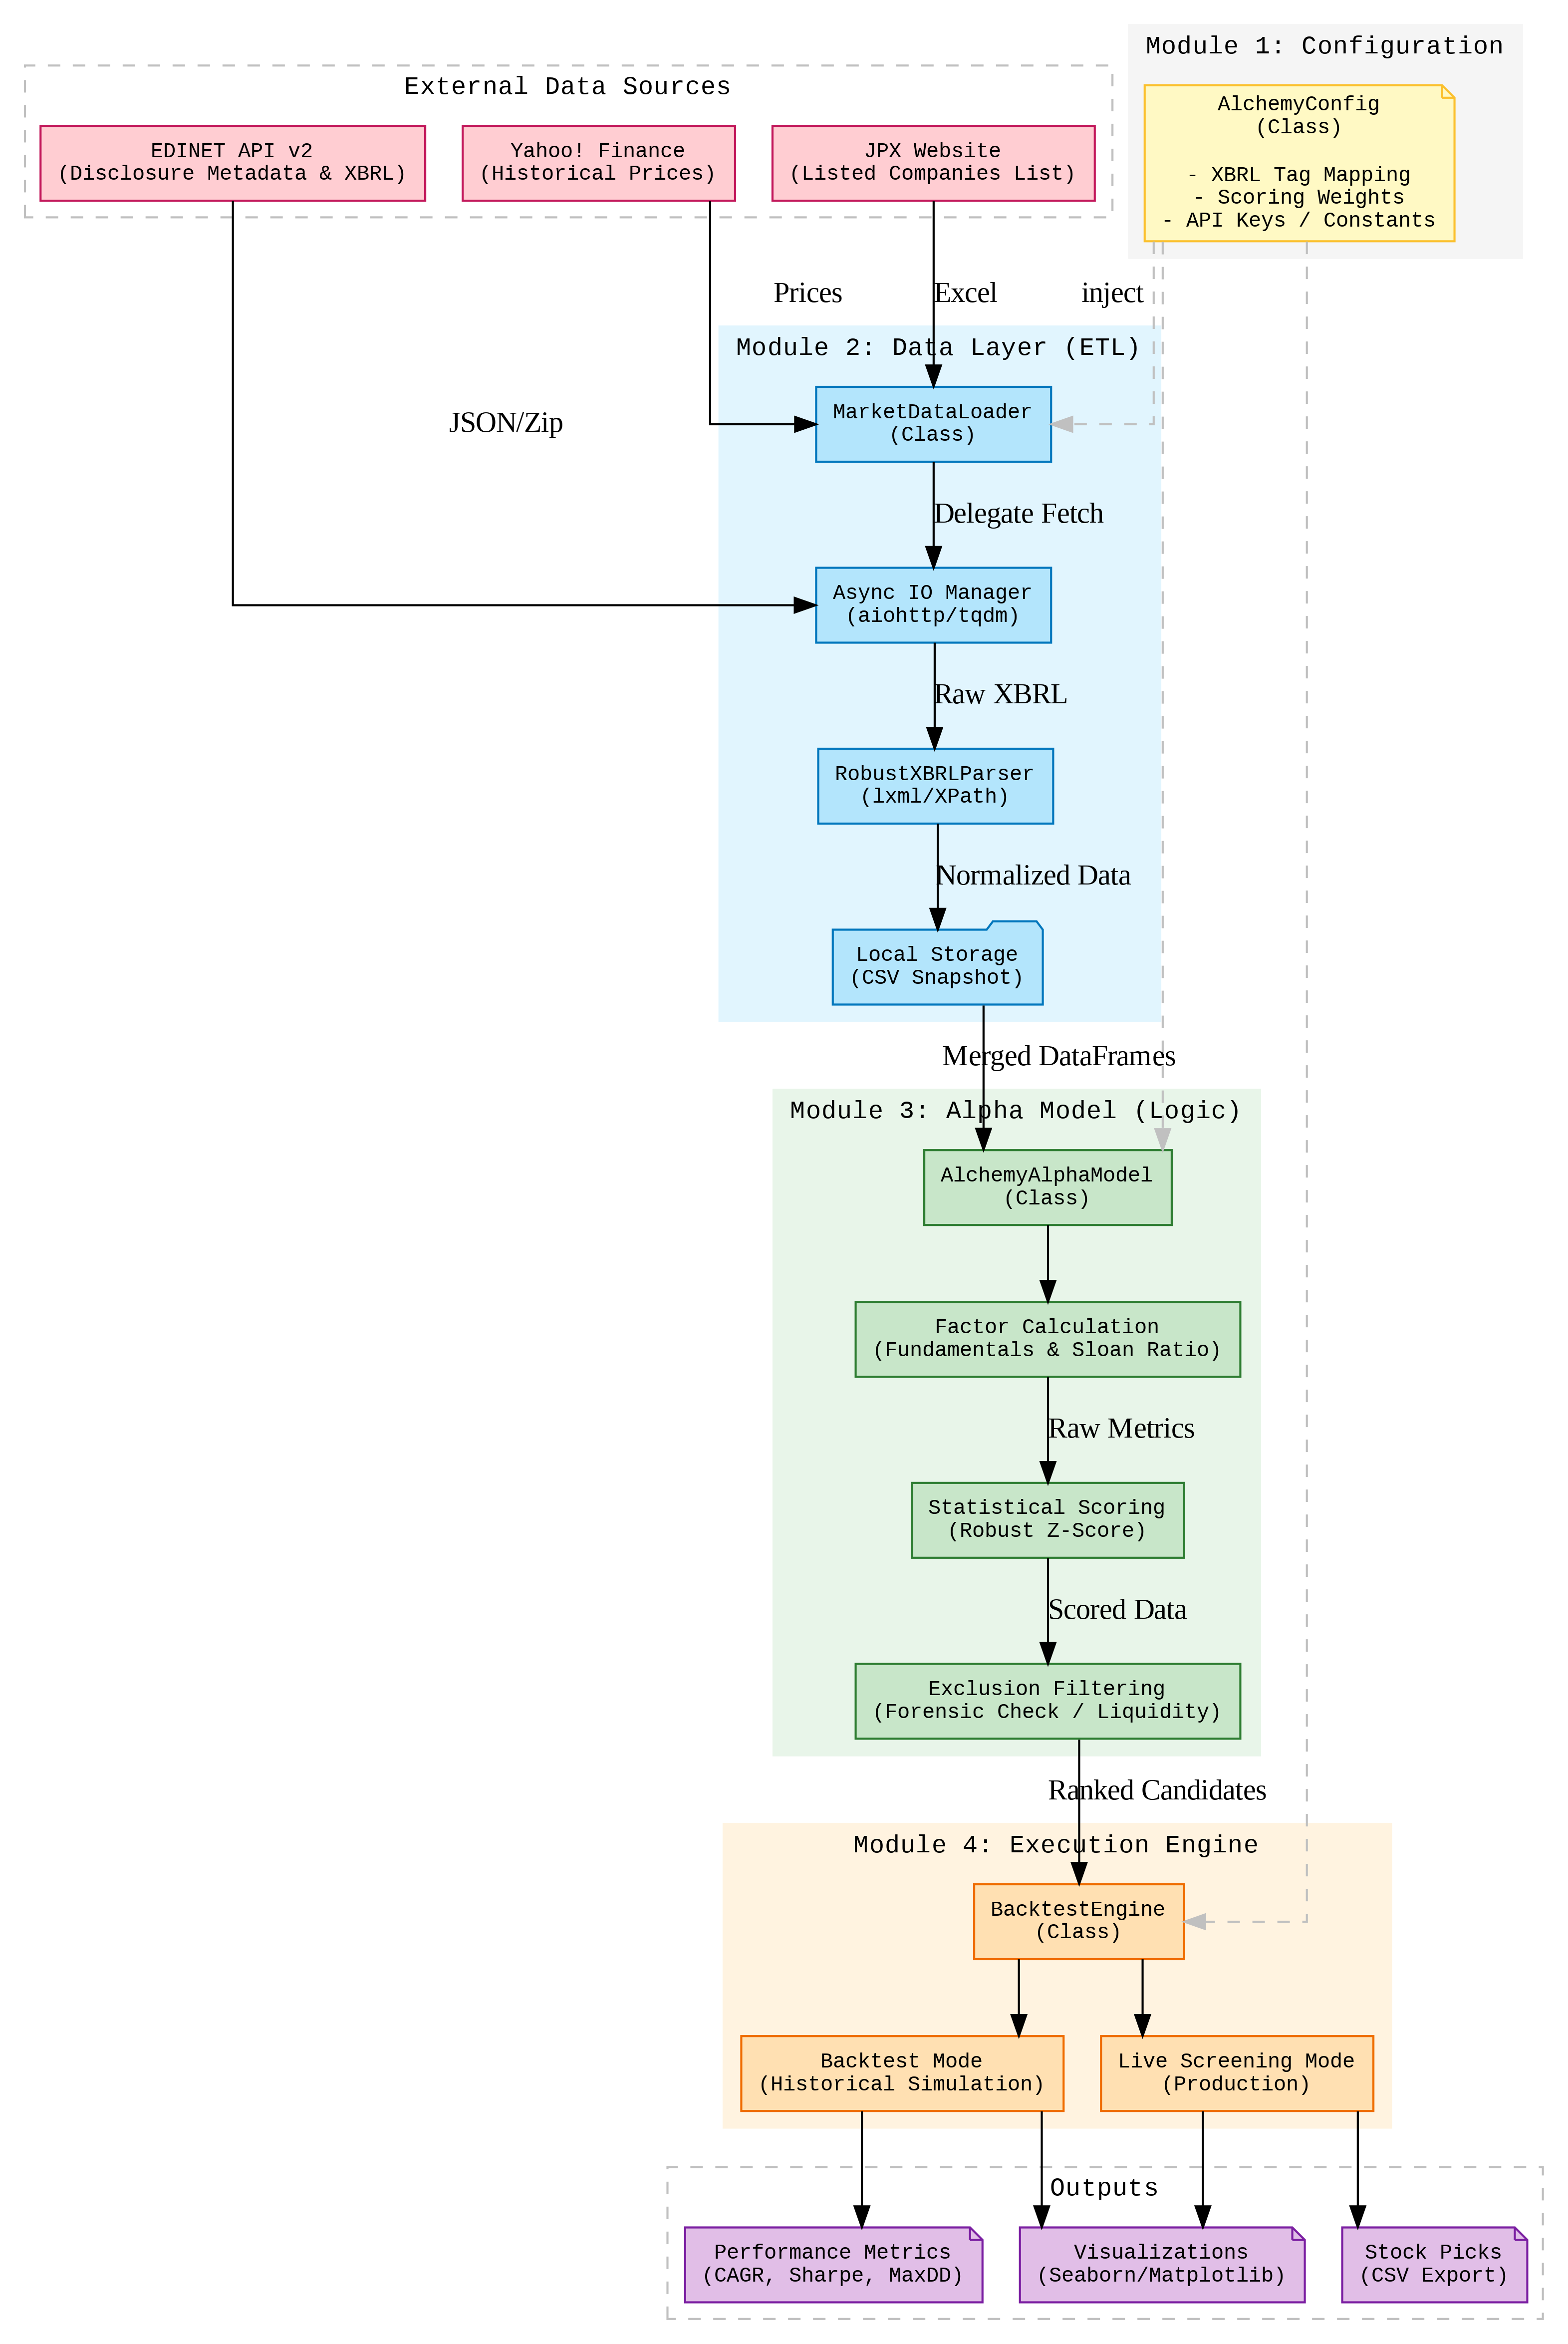
<br>
<sub>※閲覧性を優先し、アーキテクチャ図をBase64埋め込みで表示しています。</sub>

## 2. Configuration & Taxonomy Definition
研究の再現性（Reproducibility）を保証するため、戦略パラメータ、閾値、およびXBRLタグのマッピング定義を一元管理します。

### Parameter Logic (Hypothesis-Driven)
本モデルのパラメータは最適化計算（Optimization）によるものではなく、日本市場の特性に基づくヒューリスティックな初期設定を採用しています。

*   **Valuation (40% - Overweighted):**
    *   日本市場におけるバリュー効果の優位性と、東証によるPBR1倍割れ是正要請のトレンドを考慮し、Valueファクターをオーバーウェイトしています。

    *   元論文ではPER拡大をドライバーとしていますが、本モデルでは**PBR**を採用しました。

        1.  **Target Mismatch:** ターゲットとする小型成長株は、先行投資により一時的に赤字（PER算出不能）となるケースが多く、PERではユニバースが不当に縮小するため。

        2.  **Logical Consistency:** Sloan Ratioで「利益（PL）」の質を疑っている以上、バリュエーションにはPLではなく、より操作困難な「純資産（BS）」を用いる方が、フォレンジック戦略として整合するため。

        3.  **Market Catalyst:** 日本市場における「PBR1倍割れ是正要請」による資本効率改善のカタリストを捕捉するため。
    
    
*   **Quality (30%):** EPS成長の持続性を担保するため、ROA（資産効率性）を重視。
*   **Sector Mapping:**
    *   東証33業種ではサンプル数が少なくZスコアが安定しないセクター（鉱業等）があるため、**TOPIX-17区分に準拠した独自マッピング（Custom Mapping）** を行い、統計的な安定性を確保しています。

In [ ]:
# =============================================================================
# [Module 1] Configuration & Imports
# =============================================================================
# Google Colabなどで実行し、ライブラリのインストールが必要な場合は、以下のコメントアウトを外してください
# !pip install requests pandas numpy yfinance aiohttp japanize_matplotlib seaborn lxml tqdm nest_asyncio xlrd

import sys
import os
import warnings
import io
import zipfile
import datetime
import time
import asyncio
import logging
import concurrent.futures
import math
from typing import List, Tuple, Optional, Dict, Any, Set, Union
from dataclasses import dataclass, field

import requests
import pandas as pd
import numpy as np
import yfinance as yf
import aiohttp
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import etree
from tqdm.asyncio import tqdm_asyncio
from tqdm import tqdm

# Environment Setup
try:
    get_ipython()
    import nest_asyncio
    nest_asyncio.apply()
except NameError:
    pass

warnings.filterwarnings("ignore")
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

@dataclass
class AlchemyConfig:
    """戦略のパラメータおよび定数を一元管理するクラス"""

    # --- API Key ---
    def _get_api_key() -> str:
        try:
            from google.colab import userdata
            return userdata.get('EDINET_API_KEY')
        except: pass
        key = os.getenv("EDINET_API_KEY")
        if key: return key
        return ""

    EDINET_API_KEY: str = field(default_factory=_get_api_key)

    # --- Filtering Criteria ---
    MIN_MARKET_CAP_B: float = 5.0
    MAX_MARKET_CAP_B: float = 1000.0
    MAX_FCF_YIELD: float = 0.80
    MIN_PBR: float = 0.10

    # --- Scoring Weights ---
    WEIGHTS: Dict[str, float] = field(default_factory=lambda: {
        'VAL': 0.40, 'ROA': 0.30, 'TECH': 0.175, 'SIZE': 0.125
    })
    TECH_WEIGHTS: Dict[str, float] = field(default_factory=lambda: {
        'RANGE': 0.80, 'MOM': 0.20
    })

    # --- XBRL Tag Mapping ---
    XBRL_TAG_MAP: Dict[str, List[str]] = field(default_factory=lambda: {
        'Assets': ['TotalAssets', 'Assets', 'AssetsIFRS', 'TotalAssetsIFRSSummaryOfBusinessResults', 'AssetsUSGAAP', 'jppfs_cor_TotalAssets', 'ifrs-full_Assets'],
        'NetAssets': ['NetAssets', 'TotalNetAssets', 'NetAssetsSummaryOfBusinessResults', 'TotalEquity', 'Equity', 'jppfs_cor_NetAssets', 'ifrs-full_Equity'],
        'Cash': ['CashAndDeposits', 'CashAndCashEquivalents', 'CashAndCashEquivalentsIFRS', 'jppfs_cor_CashAndDeposits', 'ifrs-full_CashAndCashEquivalents'],
        'Debt': ['ShortTermLoansPayable', 'CurrentPortionOfLongTermLoansPayable', 'LongTermLoansPayable', 'BondsPayable', 'InterestBearingDebt', 'BorrowingsCurrent', 'BorrowingsNonCurrent'],
        'OpIncome': ['OperatingIncome', 'OperatingIncomeLoss', 'OperatingProfit', 'OperatingProfitIFRS', 'jppfs_cor_OperatingIncome'],
        'NetIncome': ['CurrentNetIncome', 'NetIncome', 'ProfitLoss', 'Profit', 'NetIncomeLoss', 'jppfs_cor_CurrentNetIncome', 'ifrs-full_ProfitLoss', 'ProfitLossAttributableToOwnersOfParent'],
        'Depreciation': ['Depreciation', 'DepreciationAndAmortization', 'DepreciationAndAmortizationOpeCF', 'DepreciationExpense', 'AmortizationExpense'],
        'IssuedShares': [
            'TotalNumberOfIssuedSharesSummaryOfBusinessResults', 'TotalNumberOfIssuedShares', 'TotalNumberOfIssuedSharesCommonStock', 'TotalNumberOfIssuedSharesCommonStockSummaryOfBusinessResults','IssuedShares', 'NumberOfSharesIssued',
            'NumberOfSharesIssuedSharesVotingRights', 'NumberOfIssuedSharesAsOfFiscalYearEndIssuedSharesTotalNumberOfSharesEtc',
            'NumberOfIssuedSharesAsOfFilingDateIssuedSharesTotalNumberOfSharesEtc', 'jppfs_cor_TotalNumberOfIssuedShares'
        ],
        'TreasuryShares': [
            'TreasuryStockNumberOfShares', 'jppfs_cor_TreasuryStockNumberOfShares', 'NumberOfSharesHeldInOwnNameTreasurySharesEtc',
            'TotalNumberOfSharesHeldTreasurySharesEtc', 'TreasuryStock', 'TreasuryShares'
        ],
        'OpeCF': ['NetCashProvidedByUsedInOperatingActivities', 'CashFlowsFromOperatingActivities', 'CashFlowsFromUsedInOperatingActivities'],
        'Capex': [
            'PurchaseOfPropertyPlantAndEquipmentInvCF', 'PurchaseOfPropertyPlantAndEquipment', 'PurchaseOfTangibleFixedAssets',
            'PaymentsForPropertyPlantAndEquipment', 'IncreaseInPropertyPlantAndEquipmentAndIntangibleAssets',
            'CapitalExpendituresOverviewOfCapitalExpendituresEtc', 'CapitalExpenditures'
        ]
    })

    SECTOR_MAP_17: Dict[Union[str, int], str] = field(default_factory=lambda: {
        'Fishery, Agriculture and Forestry': 'Foods', 50: 'Foods', 'Mining': 'Energy Resources', 1050: 'Energy Resources', 'Construction': 'Construction & Materials', 2050: 'Construction & Materials',
        'Foods': 'Foods', 3050: 'Foods', 'Textiles & Apparels': 'Raw Materials & Chemicals', 3100: 'Raw Materials & Chemicals', 'Pulp & Paper': 'Raw Materials & Chemicals', 3150: 'Raw Materials & Chemicals',
        'Chemicals': 'Raw Materials & Chemicals', 3200: 'Raw Materials & Chemicals', 'Pharmaceutical': 'Pharmaceutical', 3250: 'Pharmaceutical', 'Oil & Coal Products': 'Energy Resources', 3300: 'Energy Resources',
        'Rubber Products': 'Automobiles & Transportation Equipment', 3350: 'Automobiles & Transportation Equipment', 'Glass & Ceramics Products': 'Construction & Materials', 3400: 'Construction & Materials',
        'Iron & Steel': 'Steel & Nonferrous Metals', 3450: 'Steel & Nonferrous Metals', 'Nonferrous Metals': 'Steel & Nonferrous Metals', 3500: 'Steel & Nonferrous Metals', 'Metal Products': 'Construction & Materials', 3550: 'Construction & Materials',
        'Machinery': 'Machinery', 3600: 'Machinery', 'Electric Appliances': 'Electric Appliances & Precision Instruments', 3650: 'Electric Appliances & Precision Instruments', 'Transportation Equipment': 'Automobiles & Transportation Equipment', 3700: 'Automobiles & Transportation Equipment',
        'Precision Instruments': 'Electric Appliances & Precision Instruments', 3750: 'Electric Appliances & Precision Instruments', 'Other Products': 'Construction & Materials', 3800: 'Construction & Materials', 'Electric Power & Gas': 'Electric Power & Gas', 4050: 'Electric Power & Gas',
        'Land Transportation': 'Transportation & Logistics', 5050: 'Transportation & Logistics', 'Marine Transportation': 'Transportation & Logistics', 5100: 'Transportation & Logistics', 'Air Transportation': 'Transportation & Logistics', 5150: 'Transportation & Logistics',
        'Warehousing & Harbor Transportation Services': 'Transportation & Logistics', 5200: 'Transportation & Logistics', 'Information & Communication': 'IT & Services', 5250: 'IT & Services', 'Wholesale Trade': 'Commercial & Wholesale Trade', 6050: 'Commercial & Wholesale Trade',
        'Retail Trade': 'Retail Trade', 6100: 'Retail Trade', 'Banks': 'Banks', 7050: 'Banks', 'Securities & Commodity Futures': 'Financials (Ex Banks)', 7100: 'Financials (Ex Banks)', 'Insurance': 'Financials (Ex Banks)', 7150: 'Financials (Ex Banks)',
        'Other Financing Business': 'Financials (Ex Banks)', 7200: 'Financials (Ex Banks)', 'Real Estate': 'Real Estate', 8050: 'Real Estate', 'Services': 'IT & Services', 9050: 'IT & Services'
    })

## 3. Data Engineering Layer (Forensic ETL)
データの取得と正規化にリソースを集中しています。

### Class: `RobustXBRLParser`
会計監査の知見を実装したコアモジュールです。
*   **Strict Context Parsing:** XBRLのコンテキスト（時点情報）を解析し、「実績値」と「予測値」を厳密に区別することで、データ取得エラーを防いでいます。
*   **Accounting Standard Adjustment:** J-GAAP、IFRS、US-GAAP間のタグの揺らぎをマッピング辞書で吸収しています。なお、本モデルでは「タグレベルの統合」に留まり、のれん償却やリース会計などの「会計方針レベルの調整」までは行っていない点に留意が必要です。

### Class: `MarketDataLoader`
*   **Limitations of Price Data:** 株価取得には `yfinance` を使用しています。調整後終値（Adjusted Close）の扱いや、過去の上場廃止銘柄のデータ取得に限界があるため、本番運用においては有料のPoint-in-Timeデータベース（Bloomberg/FactSet等）への切り替えが推奨されます。
*   **Look-ahead Bias Control:** バックテストにおいて、提出日ベースでのフィルタリングを行い、当時の投資家が入手可能だった情報のみを使用しています(バックテスト時点より未来に提出された訂正報告書を物理的に遮断)。
*   **Async I/O:** `aiohttp` / `asyncio` を用いた非同期並列処理により、数千社分の有価証券報告書を高速に処理。

In [2]:
# =============================================================================
# [Module 2] Data Layer (ETL & Parsing)
# =============================================================================

# --- Network Helpers ---
async def fetch_with_retry_async(session: aiohttp.ClientSession, url: str, params: Optional[Dict] = None, max_retries: int = 3) -> Optional[bytes]:
    headers = {"User-Agent": "Mozilla/5.0"}
    for attempt in range(max_retries):
        try:
            async with session.get(url, params=params, headers=headers, timeout=30) as response:
                if response.status == 200: return await response.read()
                elif response.status in [404, 403]: return None
        except Exception as e:
            if attempt == max_retries - 1: logging.error(f"Network error {url}: {str(e)}")
        await asyncio.sleep(1 * (2 ** attempt))
    return None

def fetch_sync(url: str, params: Optional[Dict] = None) -> Optional[requests.Response]:
    time.sleep(0.5)
    try:
        res = requests.get(url, params=params, headers={"User-Agent": "Mozilla/5.0"}, timeout=15)
        if res.status_code == 200: return res
        elif res.status_code == 403: print(f"Auth Error (403): Check API Key for {url}")
    except Exception as e:
        logging.error(f"Sync fetch error {url}: {e}")
    return None

# --- XBRL Parser Logic ---
class RobustXBRLParser:
    """XBRLコンテンツの解析を担当するクラス"""
    def __init__(self, xbrl_content: bytes, config: AlchemyConfig, reference_date: Optional[datetime.date] = None):
        self.tree = etree.fromstring(xbrl_content)
        self.config = config
        self.reference_date = reference_date if reference_date else datetime.date.today()
        self.contexts: Dict[str, Dict[str, Any]] = {}
        self._parse_contexts()
        self.target_date: Optional[datetime.date] = None
        self._determine_target_date()

    def _parse_contexts(self) -> None:
        for ctx in self.tree.xpath(".//*[local-name()='context']"):
            cid = ctx.get("id")
            if not cid: continue
            period = ctx.xpath(".//*[local-name()='period']")
            if not period: continue

            start_date, end_date, p_type = None, None, "unknown"
            instant = period[0].xpath(".//*[local-name()='instant']")
            if instant:
                try:
                    text = instant[0].text.strip()
                    end_date = datetime.datetime.strptime(text, "%Y-%m-%d").date()
                    start_date = end_date
                    p_type = "instant"
                except: pass
            else:
                s_elem = period[0].xpath(".//*[local-name()='startDate']")
                e_elem = period[0].xpath(".//*[local-name()='endDate']")
                if s_elem and e_elem:
                    try:
                        s_text, e_text = s_elem[0].text.strip(), e_elem[0].text.strip()
                        start_date = datetime.datetime.strptime(s_text, "%Y-%m-%d").date()
                        end_date = datetime.datetime.strptime(e_text, "%Y-%m-%d").date()
                        p_type = "duration"
                    except: pass

            if not end_date: continue
            if end_date > self.reference_date + datetime.timedelta(days=90): continue
            is_consolidated = 'NonConsolidated' not in cid and 'Separate' not in cid
            self.contexts[cid] = {'type': p_type, 'start': start_date, 'end': end_date, 'is_consolidated': is_consolidated}

    def _determine_target_date(self) -> None:
        if not self.contexts: return
        anchor_tags = ['NetAssets', 'Assets', 'AssetsIFRS', 'TotalAssetsIFRSSummaryOfBusinessResults', 'Sales', 'OperatingIncome']
        candidate_dates = []
        for tag in anchor_tags:
            nodes = self.tree.xpath(f".//*[local-name()='{tag}']")
            for node in nodes:
                cid = node.get("contextRef")
                if cid in self.contexts and node.text and node.text.strip():
                    candidate_dates.append(self.contexts[cid]['end'])

        if not candidate_dates: candidate_dates = [c['end'] for c in self.contexts.values()]
        threshold = self.reference_date + datetime.timedelta(days=90)
        valid_dates = [d for d in candidate_dates if d <= threshold]
        self.target_date = max(valid_dates) if valid_dates else self.reference_date

    def get_value(self, tag_keys: List[str], rank: int = 0, prefer_consolidated: bool = True, annualize: bool = False) -> Tuple[float, int]:
        candidates = []
        if not self.contexts or not self.target_date: return 0.0, 0
        target = self.target_date
        if rank > 0:
            try: target = self.target_date.replace(year=self.target_date.year - rank)
            except ValueError: target = self.target_date - datetime.timedelta(days=365 * rank)

        margin_days = 90
        for key in tag_keys:
            nodes = self.tree.xpath(f".//*[local-name()='{key}']")
            for node in nodes:
                cid = node.get("contextRef")
                if not cid or cid not in self.contexts: continue
                val_str = node.text
                if not val_str or not val_str.strip(): continue
                ctx = self.contexts[cid]

                score = 0
                if ctx['is_consolidated'] == prefer_consolidated: score += 1000
                score -= len(cid)
                cid_lower = cid.lower()
                is_prior_context = 'prior' in cid_lower or 'prev' in cid_lower or 'ly' in cid_lower
                date_diff = abs((ctx['end'] - target).days)

                if rank == 1 and is_prior_context:
                    if ctx['end'] < self.target_date:
                        score += 8000; date_diff = 0
                if date_diff > margin_days: continue

                try:
                    val = float(val_str)
                    scale = node.get('scale')
                    if scale: val *= (10 ** int(scale))
                    if node.get('sign') == '-': val *= -1.0
                    if rank == 0 and is_prior_context: score -= 5000
                    elif rank == 1 and is_prior_context: score += 5000

                    duration_days = 0
                    if ctx['type'] == 'duration':
                        duration_days = (ctx['end'] - ctx['start']).days
                        if annualize:
                            if 80 <= duration_days <= 100: val *= 4.0
                            elif 170 <= duration_days <= 200: val *= 2.0
                            elif 260 <= duration_days <= 280: val *= (12.0/9.0)
                            elif duration_days < 350 and duration_days > 0: val *= (365.0 / duration_days)
                    candidates.append((score, val, duration_days))
                except: continue

        if not candidates: return 0.0, 0
        candidates.sort(key=lambda x: x[0], reverse=True)
        return candidates[0][1], candidates[0][2]

    def extract_metrics(self) -> Dict[str, Union[float, str]]:
        data = {}
        if not self.target_date: return {}
        tag_map = self.config.XBRL_TAG_MAP

        data['Assets'], _ = self.get_value(tag_map['Assets'], 0, annualize=False)
        data['NetAssets'], _ = self.get_value(tag_map['NetAssets'], 0, annualize=False)
        data['Cash'], _ = self.get_value(tag_map['Cash'], 0, annualize=False)
        debt = 0.0
        for tag in tag_map['Debt']:
            v, _ = self.get_value([tag], 0, annualize=False)
            debt += v
        data['Debt'] = debt
        data['IssuedShares'], _ = self.get_value(tag_map['IssuedShares'], 0, prefer_consolidated=False, annualize=False)
        raw_treasury, _ = self.get_value(tag_map['TreasuryShares'], 0, annualize=False)
        data['TreasuryShares'] = abs(raw_treasury)
        data['OpIncome'], dur_days = self.get_value(tag_map['OpIncome'], 0, annualize=True)
        data['NetIncome'], _ = self.get_value(tag_map['NetIncome'], 0, annualize=True)
        data['Depreciation'], _ = self.get_value(tag_map['Depreciation'], 0, annualize=True)
        data['OpeCF'], _ = self.get_value(tag_map['OpeCF'], 0, annualize=True)
        raw_capex, _ = self.get_value(tag_map['Capex'], 0, annualize=True)
        data['Capex'] = abs(raw_capex)

        if data['IssuedShares'] > 0 and data['TreasuryShares'] > data['IssuedShares']:
            data['TreasuryShares'] = 0.0
        data['RealShares'] = max(data['IssuedShares'] - data['TreasuryShares'], 0)
        if data['RealShares'] == 0 and data['IssuedShares'] > 0: data['RealShares'] = data['IssuedShares']

        data['EBITDA'] = data['OpIncome'] + data['Depreciation']
        data['NetDebt'] = data['Debt'] - data['Cash']
        data['FCF'] = data['OpeCF'] - data['Capex']

        prev_Assets, _ = self.get_value(tag_map['Assets'], 1, annualize=False)
        prev_OpIncome, _ = self.get_value(tag_map['OpIncome'], 1, annualize=True)
        prev_Depreciation, _ = self.get_value(tag_map['Depreciation'], 1, annualize=True)
        prev_EBITDA = prev_OpIncome + prev_Depreciation
        data['Prev_Assets'] = prev_Assets
        data['Prev_EBITDA'] = prev_EBITDA
        raw_asset_growth = (data['Assets'] - prev_Assets) / prev_Assets if prev_Assets > 0 else 0.0
        data['Asset_Growth'] = raw_asset_growth * 2.0 if 150 <= dur_days < 250 else raw_asset_growth
        data['PeriodEnd'] = self.target_date
        return data

# --- Market Data Loader ---
class MarketDataLoader:
    """外部データソース(EDINET, Yahoo)との通信およびデータセット構築(ETL)を担当"""
    def __init__(self, config: AlchemyConfig):
        self.config = config

    def get_target_list(self) -> pd.DataFrame:
        print(">>> [Loader] Fetching JPX Listed Companies...")
        url = "https://www.jpx.co.jp/english/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_e.xls"
        res = fetch_sync(url)
        if not res: return pd.DataFrame()
        try:
            df = pd.read_excel(io.BytesIO(res.content))
            cols = {c: c for c in df.columns}
            code_col = next((c for c in cols if 'Local Code' in str(c) or 'Code' in str(c)), 'Code')
            name_col = next((c for c in cols if 'Company Name' in str(c) or 'Name' in str(c)), 'Name')
            market_col = next((c for c in cols if 'Section/Products' in str(c) or 'Market' in str(c)), 'Market')
            sec_col = next((c for c in cols if '33 Sector' in str(c)), 'Sector')
            df = df.rename(columns={code_col: 'Code', name_col: 'Name', sec_col: 'Sector', market_col: 'Market'})
            df['Code'] = df['Code'].astype(str)
            df = df[df['Code'].str.len() == 4]
            return df[df['Market'].astype(str).str.contains('Standard|Growth', case=False)]
        except Exception as e:
            logging.error(f"JPX List Error: {e}")
            return pd.DataFrame()

    def scan_disclosure_metadata(self, target_codes: Set[str], reference_date: datetime.date, days_back: int) -> Dict[str, Dict[str, Any]]:
        print(f">>> [Loader] Scanning Disclosure Info ({days_back} Days prior to {reference_date})...")
        if not self.config.EDINET_API_KEY:
            print("   [ERROR] API Key is missing.")
            return {}
        doc_map = {}
        base_url = "https://disclosure.edinet-fsa.go.jp/api/v2/documents.json"
        dates = [reference_date - datetime.timedelta(days=i) for i in range(days_back)]
        for d in tqdm(dates, desc="Metadata"):
            res = fetch_sync(base_url, {'date': d, 'type': 2, 'Subscription-Key': self.config.EDINET_API_KEY})
            if not res: continue
            try:
                for item in res.json().get('results', []):
                    sec_code = item.get('secCode')
                    if not sec_code: continue
                    code = sec_code[:4]
                    if code not in target_codes: continue
                    dtype = item['docTypeCode']
                    desc = item.get('docDescription', '')
                    is_target = False
                    if dtype in ['010', '120', '130', '150']: is_target = True
                    elif dtype == '140' and any(q in desc for q in ['第2', '第２', '第二', 'Quarter']): is_target = True
                    if is_target:
                        if code not in doc_map: doc_map[code] = item
            except: continue
        return doc_map

    async def _process_xbrl_task(self, session: aiohttp.ClientSession, code: str, doc_info: Dict[str, Any], semaphore: asyncio.Semaphore, reference_date: datetime.date) -> Optional[Dict[str, Any]]:
        async with semaphore:
            url = f"https://disclosure.edinet-fsa.go.jp/api/v2/documents/{doc_info['docID']}"
            content = await fetch_with_retry_async(session, url, {'type': 1, 'Subscription-Key': self.config.EDINET_API_KEY})
            if not content: return None
            try:
                with zipfile.ZipFile(io.BytesIO(content)) as z:
                    xbrl_files = [f for f in z.namelist() if f.endswith('.xbrl') and 'PublicDoc' in f]
                    if not xbrl_files: return None
                    with z.open(xbrl_files[0]) as f:
                        parser = RobustXBRLParser(f.read(), self.config, reference_date)
                        metrics = parser.extract_metrics()
                        metrics['Code'] = code
                        return metrics
            except Exception as e:
                logging.warning(f"XBRL process error for {code}: {e}")
                return None

    def download_xbrl_data(self, doc_map: Dict[str, Dict[str, Any]], reference_date: datetime.date) -> pd.DataFrame:
        print(f">>> [Loader] XBRL Async Download & Parsing (Tasks: {len(doc_map)})...")
        if not doc_map: return pd.DataFrame()
        async def _run_async_etl():
            semaphore = asyncio.Semaphore(10)
            tasks = []
            async with aiohttp.ClientSession() as session:
                for code, info in doc_map.items():
                    tasks.append(self._process_xbrl_task(session, code, info, semaphore, reference_date))
                results = await tqdm_asyncio.gather(*tasks)
            return [r for r in results if r is not None]

        loop = asyncio.get_event_loop()
        df_fin = loop.run_until_complete(_run_async_etl()) if loop.is_running() else asyncio.run(_run_async_etl())
        return pd.DataFrame(df_fin)

    def fetch_historical_prices(self, codes: List[str], entry_date_str: str, exit_date_str: str) -> pd.DataFrame:
        print(f">>> [Loader] Fetching Historical Prices (PIT: {entry_date_str} to {exit_date_str})...")
        if not codes: return pd.DataFrame()
        tickers = [f"{c}.T" for c in codes]
        target_dt = datetime.datetime.strptime(entry_date_str, "%Y-%m-%d").date()
        eval_dt = datetime.datetime.strptime(exit_date_str, "%Y-%m-%d").date()

        def get_historical_info(ticker_symbol: str) -> Optional[Dict[str, float]]:
            try:
                t = yf.Ticker(ticker_symbol)
                hist_start = (target_dt - datetime.timedelta(days=400)).strftime("%Y-%m-%d")
                hist_end = (eval_dt + datetime.timedelta(days=10)).strftime("%Y-%m-%d")
                hist_adj = t.history(start=hist_start, end=hist_end, auto_adjust=True)
                if hist_adj.empty: return None
                hist_raw = t.history(start=hist_start, end=hist_end, auto_adjust=False)
                if hist_raw.empty: hist_raw = hist_adj.copy()

                def get_price(d, df, method='close'):
                    if df.index.tz is not None: df.index = df.index.tz_localize(None)
                    mask = df.index.date <= d if method == 'close' else df.index.date > d
                    sub = df[mask]
                    if sub.empty: return None
                    return sub.iloc[-1]['Close'] if method == 'close' else sub.iloc[0]['Open']

                entry_raw = get_price(target_dt, hist_raw, 'close')
                entry_adj = get_price(target_dt, hist_adj, 'open')
                exit_adj = get_price(eval_dt, hist_adj, 'close')

                if not entry_raw: return None
                entry_p = entry_adj if entry_adj else entry_raw
                exit_p = exit_adj if exit_adj else 0.0

                mom_dt = (pd.Timestamp(target_dt) - pd.DateOffset(months=1)).date()
                mom_p = get_price(mom_dt, hist_adj, 'close')
                momentum = (entry_p / mom_p - 1.0) if mom_p and mom_p > 0 else 0.0

                p_range = 0.5
                try:
                    mask_rng = (hist_raw.index.date > target_dt - datetime.timedelta(days=365)) & (hist_raw.index.date <= target_dt)
                    sub = hist_raw[mask_rng]
                    if not sub.empty:
                        h, l = sub['High'].max(), sub['Low'].min()
                        if h > l: p_range = (entry_raw - l) / (h - l)
                except: pass

                return {
                    'Code': ticker_symbol.replace('.T', ''), 'Price_Raw': float(entry_raw),
                    'Price': float(entry_p), 'Exit_Price': float(exit_p),
                    'Actual_Return': (exit_p / entry_p - 1.0) if entry_p > 0 and exit_p > 0 else 0.0,
                    'Price_Range': float(p_range), 'Momentum_1M': float(momentum)
                }
            except: return None

        with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
            results = list(tqdm(executor.map(get_historical_info, tickers), total=len(tickers), desc="Threaded Fetch"))
        return pd.DataFrame([r for r in results if r is not None])

    def fetch_current_prices(self, codes: List[str]) -> pd.DataFrame:
        print(f">>> [Loader] Fetching Prices & Market Cap (Symbols: {len(codes)})...")
        if not codes: return pd.DataFrame()
        tickers = [f"{c}.T" for c in codes]

        def get_info(ticker_symbol: str) -> Optional[Dict[str, float]]:
            try:
                t = yf.Ticker(ticker_symbol)
                fi = t.fast_info
                price = fi.last_price
                if pd.isna(price): return None
                mkt_cap = fi.market_cap
                if pd.isna(mkt_cap): mkt_cap = price * t.info.get('sharesOutstanding', 0)

                high52, low52 = fi.year_high, fi.year_low
                price_range = (price - low52)/(high52 - low52) if high52 > low52 else 0.5

                momentum_1m = 0.0
                try:
                    hist = t.history(period="1mo")
                    if not hist.empty: momentum_1m = (price / hist['Close'].iloc[0]) - 1.0
                except: pass

                return {
                    'Code': ticker_symbol.replace('.T', ''), 'Price_Raw': float(price), 'Price': float(price),
                    'MarketCap': float(mkt_cap) if mkt_cap else 0.0, 'Price_Range': float(price_range), 'Momentum_1M': float(momentum_1m)
                }
            except: return None

        with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
            results = list(tqdm(executor.map(get_info, tickers), total=len(tickers)))
        return pd.DataFrame([r for r in results if r is not None])

    def load_dataset_for_backtest(self, entry_date: str, exit_date: str, scan_days_back: int = 120) -> pd.DataFrame:
        """
        【New】バックテスト用の完成されたデータセットを提供するメソッド
        Engine内にあった「キャッシュ確認・XBRL取得・結合」の全ETLロジックをここに集約。
        """
        snapshot_file = f'alchemy_snapshot_{entry_date}.csv'

        # 1. 財務データ (キャッシュ確認 or 作成)
        if os.path.exists(snapshot_file):
            print(f"   [Loader] Loading financial snapshot: {entry_date} ...", end="")
            df_fin_merged = pd.read_csv(snapshot_file)
            df_fin_merged['Code'] = df_fin_merged['Code'].astype(str)
            print(" Done.")
        else:
            print(f"   [Loader] Generating new snapshot for {entry_date}...")
            df_jpx = self.get_target_list()
            if df_jpx.empty: return pd.DataFrame()

            entry_dt = datetime.datetime.strptime(entry_date, "%Y-%m-%d").date()
            doc_map = self.scan_disclosure_metadata(set(df_jpx['Code']), entry_dt, days_back=scan_days_back)
            df_xbrl = self.download_xbrl_data(doc_map, reference_date=entry_dt)

            if df_xbrl.empty: return pd.DataFrame()

            df_fin_merged = df_jpx.merge(df_xbrl, on='Code', how='inner')
            df_fin_merged['DocTitle'] = df_fin_merged['Code'].map(lambda c: doc_map.get(c, {}).get('docDescription', ''))
            df_fin_merged.to_csv(snapshot_file, index=False)

        # 2. 株価データ (都度取得)
        df_price = self.fetch_historical_prices(df_fin_merged['Code'].unique().tolist(), entry_date, exit_date)
        if df_price.empty: return pd.DataFrame()

        # 3. 結合して返却
        return df_fin_merged.merge(df_price, on='Code', how='inner')

## 4. Alpha Model (The Logic Core)
純粋な「投資判断ロジック」です。

### 4.1. Accounting Forensics: Modified Sloan Ratio
**「利益の質（Earnings Quality）と見積もりのリスク」**

現在の収益認識会計基準（ASBJ Statement No.29等）は「支配の移転」に基づいて収益を認識しますが、その過程には「履行義務の充足度（進捗率）」や「変動対価」など、 **経営者の裁量による見積もり要素（Management Estimates）** が多分に含まれます。
これらの会計上の見積もりが過大である場合、将来の減損や収益の取り消しリスクが高まると考えられます。本モデルでは、営業外損益や特別損益に計上されるノンキャッシュ項目（評価損益や減損等）も含めた、**より厳格な利益の質（Earnings Quality）** を評価するため、営業利益ではなく**当期純利益（Net Income）** を用いた修正スローンレシオを採用しました。

$$ \text{Modified Sloan Ratio} = \frac{\text{Net Income} - \text{Operating Cash Flow}}{\text{Average Total Assets}} $$

*   **Logic:** $| \text{Sloan Ratio} | > 0.10$ （資産の10%を超える乖離がある場合、利益の質が低いと判断し除外することで、将来のリスクを**軽減 (Mitigate)** します）

### 4.2. Statistical Normalization
各ファクターのスコアリングにあたっては、データの分布特性に応じた処理を行っています。
*   **Log Transformation:** 時価総額（Size）やPBRなど、対数正規分布に近い右裾の長い分布を持つ指標には対数変換を適用し、正規性を近似させています。
*   **Robust Z-Score:** 外れ値の影響を排除するため、平均・標準偏差ではなく、**中央値（Median）とMAD（Median Absolute Deviation）** を用いた**TOPIX-17業種区分ごとのセクターバイアスを排除した**Zスコアで標準化を行っています。

### 4.3. Capital Allocation Check
日本企業にありがちな「現預金の過剰な滞留」や「非効率な資産拡大（Empire Building）」へのペナルティとして、資産増加に見合う利益成長（Marginal ROA）を確認するフィルタを導入しています。

In [3]:
# =============================================================================
# [Module 3] Alpha Model (The "Brain")
# =============================================================================
class AlchemyAlphaModel:
    """論文ロジックの実装クラス（純粋関数的動作）"""
    def __init__(self, config: AlchemyConfig):
        self.config = config

    def calculate_factors(self, df_merged: pd.DataFrame) -> pd.DataFrame:
        print(">>> [Model] Calculating Fundamentals & Risk Checks...")
        df = df_merged.copy()
        cols_to_num = ['Price_Raw', 'RealShares', 'NetDebt', 'FCF', 'EBITDA', 'Assets', 'NetAssets',
                       'Prev_Assets', 'Prev_EBITDA', 'Price_Range', 'Momentum_1M', 'Asset_Growth',
                       'OpIncome', 'NetIncome', 'OpeCF']
        for c in cols_to_num:
            if c in df.columns: df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0.0)

        if 'MarketCap' not in df.columns or df['MarketCap'].sum() == 0:
             df['MarketCap'] = df['Price_Raw'] * df['RealShares']
        df = df[df['MarketCap'] > 0].copy()

        df['TEV'] = df['MarketCap'] + df['NetDebt']
        df['TEV'] = np.where(df['TEV'] <= 0, df['MarketCap'], df['TEV'])
        df['TEV_B'] = df['TEV'] / 1e9
        df['MarketCap_B'] = df['MarketCap'] / 1e9
        df['FCF_Yield'] = df['FCF'] / df['MarketCap']
        df['ROA'] = np.where(df['Assets'] > 0, df['EBITDA'] / df['Assets'], 0.0)
        df['PBR'] = np.where(df['NetAssets'] > 0, df['MarketCap'] / df['NetAssets'], np.nan)

        df['Delta_Assets'] = df['Assets'] - df['Prev_Assets']
        df['Delta_EBITDA'] = df['EBITDA'] - df['Prev_EBITDA']
        prev_roa = np.where(df['Prev_Assets'] > 0, df['Prev_EBITDA'] / df['Prev_Assets'], 0.05)
        required_growth = df['Delta_Assets'] * np.maximum(prev_roa, 0.05)
        df['Is_Efficient'] = np.where(df['Delta_Assets'] > 0, df['Delta_EBITDA'] >= required_growth, True)

        # Fraud Risk
        avg_assets = np.where(df['Prev_Assets'] > 0, (df['Assets'] + df['Prev_Assets']) / 2.0, df['Assets'])
        avg_assets = np.where(avg_assets == 0, np.nan, avg_assets)
        if 'NetIncome' not in df.columns: df['NetIncome'] = 0.0
        net_income = np.where(df['NetIncome'] != 0, df['NetIncome'], df['OpIncome'])
        df['Sloan_Ratio'] = (net_income - df['OpeCF']) / avg_assets
        df['Fraud_Flag'] = np.where(df['Sloan_Ratio'].abs() > 0.10, 1, 0)

        cols = ['Code', 'Name', 'Sector', 'Market', 'Price', 'MarketCap_B', 'TEV_B', 'Price_Range',
                'Momentum_1M', 'FCF_Yield', 'PBR', 'ROA', 'Asset_Growth', 'Is_Efficient', 'FCF',
                'DocTitle', 'Actual_Return', 'Exit_Price', 'Fraud_Flag']
        if 'DocTitle' not in df.columns: df['DocTitle'] = ''
        return df[[c for c in cols if c in df.columns]].copy()

    def _calc_robust_z(self, series: pd.Series, use_log: bool = False) -> np.ndarray:
        vals = pd.to_numeric(series, errors='coerce').fillna(0).values
        if use_log: vals = np.log1p(np.maximum(vals, 1e-9))
        median = np.median(vals)
        mad = np.median(np.abs(vals - median))
        if mad == 0: return np.zeros(len(vals))
        z = 0.6745 * (vals - median) / mad
        return np.clip(z, -3.5, 3.5)

    def compute_scores(self, df_res: pd.DataFrame) -> pd.DataFrame:
        print(">>> [Model] Scoring & Ranking... (Sector Neutral)")
        if df_res.empty: return pd.DataFrame()
        df_res['Sector17'] = df_res['Sector'].map(self.config.SECTOR_MAP_17).fillna('Others')

        df_res['z_fcf'] = df_res.groupby('Sector17')['FCF_Yield'].transform(lambda x: self._calc_robust_z(x, False))
        df_res['z_roa'] = df_res.groupby('Sector17')['ROA'].transform(lambda x: self._calc_robust_z(x, False))
        df_res['z_mom'] = df_res.groupby('Sector17')['Momentum_1M'].transform(lambda x: self._calc_robust_z(x, False))

        df_res['Price_Range'] = df_res['Price_Range'].fillna(0.5)
        df_res['z_tech'] = -df_res.groupby('Sector17')['Price_Range'].transform(lambda x: self._calc_robust_z(x, False))
        df_res['z_pbr'] = -df_res.groupby('Sector17')['PBR'].transform(lambda x: self._calc_robust_z(x, True))
        df_res['z_size'] = -df_res.groupby('Sector17')['TEV_B'].transform(lambda x: self._calc_robust_z(x, True))

        w, wt = self.config.WEIGHTS, self.config.TECH_WEIGHTS
        df_res['S_Val'] = (df_res['z_fcf'] * 0.6 + df_res['z_pbr'] * 0.4)
        df_res['S_ROA'] = df_res['z_roa']
        df_res['S_Tech'] = (df_res['z_tech'] * wt['RANGE']) + (df_res['z_mom'] * wt['MOM'])
        df_res['S_Size'] = df_res['z_size']

        m_fcf = self._calc_robust_z(df_res['FCF_Yield'], False)
        m_pbr = self._calc_robust_z(df_res['PBR'], True)
        m_roa = self._calc_robust_z(df_res['ROA'], False)
        df_res['M_Val'] = (m_fcf * 0.6 + (-m_pbr) * 0.4)
        df_res['M_ROA'] = m_roa

        df_res['Total_Score'] = ((df_res['S_Val'] * 0.7 + df_res['M_Val'] * 0.3) * w['VAL'] +
                                 (df_res['S_ROA'] * 0.7 + df_res['M_ROA'] * 0.3) * w['ROA'] +
                                 df_res['S_Tech'] * w['TECH'] + df_res['S_Size'] * w['SIZE'])
        return df_res

    def apply_filters(self, df_scored: pd.DataFrame) -> pd.DataFrame:
        c = self.config
        initial_count = len(df_scored)
        mask = (
            (df_scored['MarketCap_B'] >= c.MIN_MARKET_CAP_B) &
            (df_scored['MarketCap_B'] < c.MAX_MARKET_CAP_B) &
            (df_scored['FCF_Yield'] < c.MAX_FCF_YIELD) &
            (df_scored['PBR'] > c.MIN_PBR) &
            (df_scored['FCF'] > 0) &
            (df_scored['Asset_Growth'] >= 0) &
            (df_scored['Is_Efficient'] == True) &
            (df_scored['Fraud_Flag'] == 0)
        )
        df = df_scored[mask].copy()
        print(f"   -> Ranked & Filtered: {initial_count} -> {len(df)}")
        return df.sort_values('Total_Score', ascending=False)

    def run(self, df_raw: pd.DataFrame) -> pd.DataFrame:
        df_factors = self.calculate_factors(df_raw)
        df_scored = self.compute_scores(df_factors)
        return self.apply_filters(df_scored)

## 5. Execution Engine (Orchestrator)
「データ（Loader）」と「ロジック（Model）」を結合し、シミュレーションを実行するエンジンクラスです。

*   **Modular Design (関心の分離):**
    データ取得、計算ロジック、実行環境を独立したクラスとして設計しています。これにより、コードの再利用性を高め、将来的なWebアプリケーション化やAPI化にも柔軟に対応可能な構造としています。

In [4]:
# =============================================================================
# [Module 4] Execution Engine (Backtest & Live) - With Risk Analytics
# =============================================================================
class BacktestEngine:
    """
    データ(Loader)とロジック(Model)を組み合わせて実行するエンジン。
    過去検証(Backtest)と本番実行(Live)の両方を担当する。
    【修正】リスク分析機能(Sharpe/MaxDD)を追加実装。
    """
    def __init__(self, config: AlchemyConfig, model: AlchemyAlphaModel, data_loader: MarketDataLoader):
        self.config = config
        self.model = model
        self.loader = data_loader

    # ==========================================
    # [View Layer] 表示・可視化機能
    # ==========================================
    def display_top_picks(self, df_res: pd.DataFrame, top_n: int = 30) -> None:
        if df_res.empty: return
        print("-" * 110)
        has_return = 'Actual_Return' in df_res.columns
        header = f"{'Code':<6} {'Name':<18} {'Sector':<18} {'Price':>8} {'Mkv(B)':>8} {'P_Rng':>6} {'Mom1M':>7} {'FCF%':>7} {'PBR':>6} {'ROA':>6} {'Score':>6}"
        if has_return: header += f" {'Return':>7}"
        print(header); print("-" * 110)

        for _, row in df_res.head(top_n).iterrows():
            try:
                name = str(row['Name'])[:16] + '..' if len(str(row['Name'])) > 16 else str(row['Name'])
                sec = str(row['Sector17'])[:16] + '..' if len(str(row['Sector17'])) > 16 else str(row['Sector17'])
                fcf_y, pbr, roa = row.get('FCF_Yield',0), row.get('PBR',0), row.get('ROA',0)

                line = (f"{str(row['Code']):<6} {name:<18} {sec:<18} {row['Price']:>8,.0f} {row['MarketCap_B']:>8.1f} {row['Price_Range']:>6.2f} "
                        f"{row['Momentum_1M']:>7.1%} {fcf_y:>7.1%} {pbr:>6.2f} {roa:>6.1%} {row['Total_Score']:>6.2f}")
                if has_return: line += f" {row.get('Actual_Return', 0.0):>7.1%}"
                print(line)
            except: continue
        print("-" * 110)

    def visualize_results(self, df_res: pd.DataFrame, top_n: int = 30) -> None:
        print(">>> [Visualizing] Generating Strategy Analytics Charts...")
        if df_res.empty: return
        top_picks = df_res.sort_values('Total_Score', ascending=False).head(top_n)

        sns.set(style="whitegrid"); plt.rcParams['font.family'] = 'IPAexGothic'
        plt.figure(figsize=(20, 12)); plt.subplots_adjust(hspace=0.3)

        plt.subplot(2, 2, 1)
        sns.scatterplot(data=df_res, x='FCF_Yield', y='ROA', color='lightgray', alpha=0.5, label='Universe')
        sns.scatterplot(data=top_picks, x='FCF_Yield', y='ROA', color='red', s=100, marker='*', label='Top Picks')
        plt.title('Quality (ROA) vs Value (FCF Yield) Map', fontsize=14, fontweight='bold'); plt.legend()

        plt.subplot(2, 2, 2)
        sns.histplot(data=df_res, x='Total_Score', kde=True, bins=30, color='steelblue')
        if not top_picks.empty: plt.axvline(top_picks['Total_Score'].min(), color='red', linestyle='--', label='Cutoff')
        plt.title('Total Score Distribution', fontsize=14, fontweight='bold'); plt.legend()

        plt.subplot(2, 1, 2)
        try:
            order = df_res.groupby('Sector17')['Total_Score'].median().sort_values(ascending=False).index
            sns.boxplot(data=df_res, x='Sector17', y='Total_Score', order=order, palette='viridis')
            plt.title('Sector-Neutrality Check', fontsize=14, fontweight='bold'); plt.xticks(rotation=45, ha='right')
        except: pass
        plt.tight_layout(); plt.show()

    # ==========================================
    # [Analytics Layer] リスク指標計算 (New)
    # ==========================================
    def _calculate_risk_metrics(self, returns_list: List[float], risk_free_rate: float = 0.0) -> Dict[str, float]:
        """
        【New】リターン配列からパフォーマンス指標(CAGR, Sharpe, MaxDD)を一括計算するメソッド。
        パイプライン設計における「分析コンポーネント」として機能します。
        """
        if not returns_list:
            return {'CAGR': 0.0, 'Sharpe': 0.0, 'MaxDD': 0.0, 'Vol': 0.0, 'CumRet': 0.0}

        # Numpy配列化（高速化・便利化）
        rets = np.array(returns_list)

        # 1. CAGR (年平均成長率)
        # 累積リターン = (1+r1)*(1+r2)*... - 1
        cumulative_return = np.prod(1.0 + rets) - 1.0
        n_years = len(rets)
        cagr = (1.0 + cumulative_return) ** (1.0 / n_years) - 1.0 if n_years > 0 else 0.0

        # 2. Volatility (標準偏差)
        # 年次リターンなので、その標準偏差がそのまま年率ボラティリティになります
        vol = np.std(rets, ddof=1) if len(rets) > 1 else 0.0

        # 3. Sharpe Ratio (シャープレシオ)
        # (平均リターン - 無リスク金利) / 標準偏差
        mean_ret = np.mean(rets)
        sharpe = (mean_ret - risk_free_rate) / vol if vol > 1e-9 else 0.0

        # 4. Max Drawdown (最大ドローダウン)
        # 資産曲線の作成
        equity_curve = np.cumprod(1.0 + rets)
        equity_curve = np.insert(equity_curve, 0, 1.0) # 初期値1.0を追加

        # 累積最大資産 (High Water Mark)
        running_max = np.maximum.accumulate(equity_curve)

        # ドローダウン (現在の資産 / 過去最高値 - 1)
        drawdowns = (equity_curve - running_max) / np.maximum(running_max, 1e-9) # ゼロ除算防止
        max_dd = np.min(drawdowns) # 負の値になる

        return {
            'CAGR': cagr,
            'Sharpe': sharpe,
            'MaxDD': max_dd,
            'Vol': vol,
            'CumRet': cumulative_return
        }

    # ==========================================
    # [Execution Layer] バックテスト実行ロジック
    # ==========================================
    def _calc_cumulative(self, returns_list: List[float]) -> float:
        """複利計算ヘルパー（旧互換用）"""
        res = 1.0
        for r in returns_list: res *= (1.0 + r)
        return res - 1.0

    def run_period(self, entry_date: str, exit_date: str, scan_days_back: int = 120, display_top: bool = True) -> pd.DataFrame:
        print(f"\n   Processing: {entry_date} -> {exit_date}")

        # 1. Pipeline: Load Data (from Loader)
        df_merged = self.loader.load_dataset_for_backtest(entry_date, exit_date, scan_days_back)
        if df_merged.empty:
            print("   [Skip] No data available.")
            return pd.DataFrame()

        # 2. Pipeline: Calculate Alpha (from Model)
        df_final = self.model.run(df_merged)

        # 3. Pipeline: Report
        if display_top and not df_final.empty:
            print(f"   [Top Picks for {entry_date}]")
            self.display_top_picks(df_final, top_n=20)
            top = df_final.iloc[0]
            ret_str = f", Return: {top['Actual_Return']:.1%}" if 'Actual_Return' in top else ""
            print(f"   -> Top 1: {top['Name']} (Score: {top['Total_Score']:.2f}{ret_str})")
        return df_final

    def run_annual_rebalancing_strategy(self, start_year: int = 2016, end_year: int = 2025):
        print("\n" + "#"*110 + "\n>>> STRATEGY 1: Annual Rebalancing (Risk & Return Analytics)\n" + "#"*110)

        # ポートフォリオ別のリターン履歴を保存するコンテナ
        portfolio_buckets = [10, 15, 20, 30]
        history_returns = {n: [] for n in portfolio_buckets}

        # --- 1. Simulation Phase (Data Generation) ---
        for year in range(start_year, end_year):
            df_result = self.run_period(f"{year}-06-30", f"{year+1}-06-30")
            if not df_result.empty:
                metrics_str = []
                for n in portfolio_buckets:
                    # Top N の平均リターンを計算 (等ウェイト)
                    avg_ret = df_result.head(n)['Actual_Return'].mean()
                    history_returns[n].append(avg_ret)
                    metrics_str.append(f"Top{n}: {avg_ret:>6.1%}")
                print(f"   [Year {year} Result] " + " | ".join(metrics_str))
            else:
                for n in portfolio_buckets: history_returns[n].append(0.0)

        # --- 2. Analytics Phase (Calculation & Reporting) ---
        print("\n" + "="*110)
        print(">>> STRATEGY 1 SUMMARY: Risk-Adjusted Performance")
        print("="*110)
        # ヘッダーにSharpeとMaxDDを追加
        print(f"{'Portfolio':<10} | {'CAGR':<9} | {'Sharpe':<8} | {'MaxDD':<9} | {'Vol(Ann)':<9} | {'WinRate':<8} | {'Total Ret':<10}")
        print("-" * 110)

        for n in sorted(history_returns.keys()):
            rets = history_returns[n]
            if not rets: continue

            # 【New】分析メソッド呼び出し
            m = self._calculate_risk_metrics(rets)

            # その他の指標
            win_rate = sum(r > 0 for r in rets) / len(rets)

            # 表示用フォーマット関数
            def fmt(v, is_pct=True):
                if pd.isna(v): return "   N/A   "
                return f"{v:>9.1%}" if is_pct else f"{v:>8.2f}"

            print(f"Top {n:<6} | {fmt(m['CAGR'])} | {fmt(m['Sharpe'], False)} | {fmt(m['MaxDD'])} | {fmt(m['Vol'])} | {fmt(win_rate)} | {fmt(m['CumRet'])}")
        print("="*110)
        print(" * Sharpe Ratio assuming Risk Free Rate = 0.0%")
        print(" * Max Drawdown calculated from annual equity curve")

    def run_buy_and_hold_strategy(self, start_years: list[int], final_exit_date: str):
        print("\n" + "#"*80 + "\n>>> STRATEGY 2: Buy & Hold\n" + "#"*80)
        print(f"{'Entry Date':<12} | {'Duration':<10} | {'Top 10':<10} | {'Top 15':<10} | {'Top 20':<10} | {'Top 30':<10}\n" + "-" * 75)
        for start_year in start_years:
            entry_date = f"{start_year}-06-30"
            if entry_date > final_exit_date: continue
            df_bh = self.run_period(entry_date, final_exit_date, display_top=False)
            if not df_bh.empty:
                dur = round((datetime.datetime.strptime(final_exit_date, "%Y-%m-%d") - datetime.datetime.strptime(entry_date, "%Y-%m-%d")).days / 365.25, 1)
                r = {n: df_bh.head(n)['Actual_Return'].mean() for n in [10, 15, 20, 30]}
                print(f"{entry_date:<12} | {dur} Years   | {r[10]:>9.1%} | {r[15]:>9.1%} | {r[20]:>9.1%} | {r[30]:>9.1%}")
        print("="*80)

    # ==========================================
    # [Live Layer] ライブスクリーニング実行
    # ==========================================
    def run_live_screening(self, top_n: int = 50):
        """本日時点のデータでスクリーニングを実行"""
        print("\n" + "="*50 + "\n>>> STARTING LIVE SCREENING...\n" + "="*50)
        today_dt = datetime.date.today()
        today_str = today_dt.strftime("%Y-%m-%d")
        db_filename = f'alchemy_live_{today_str}.csv'

        # 1. Pipeline: Load Data (Cache or Fresh)
        if os.path.exists(db_filename):
            print(f">>> Loading live cache: {today_str}...")
            df_merged = pd.read_csv(db_filename)
            df_merged['Code'] = df_merged['Code'].astype(str)
        else:
            # Loaderの機能を組み合わせてライブデータを構築
            df_jpx = self.loader.get_target_list()
            if df_jpx.empty: return

            # 過去1年分のXBRLをスキャンして最新を見つける
            doc_map = self.loader.scan_disclosure_metadata(set(df_jpx['Code']), today_dt, days_back=365)
            df_fin = self.loader.download_xbrl_data(doc_map, reference_date=today_dt)
            if df_fin.empty:
                print(">>> No financial data found."); return

            # 最新株価取得
            df_price = self.loader.fetch_current_prices(df_fin['Code'].unique().tolist())

            # 結合
            df_merged = df_jpx.merge(df_fin, on='Code', how='inner').merge(df_price, on='Code', how='inner')
            df_merged['DocTitle'] = df_merged['Code'].map(lambda c: doc_map.get(c, {}).get('docDescription', ''))
            df_merged.to_csv(db_filename, index=False)
            print(f">>> [ETL Complete] Data saved: {db_filename}")

        # 2. Pipeline: Calculate Alpha
        df_final = self.model.run(df_merged)

        # 3. Pipeline: Report
        self.display_top_picks(df_final, top_n=top_n)
        self.visualize_results(df_final, top_n=top_n)

## 6. System Initialization
各コンポーネントを結合し、分析パイプラインを起動します。

In [ ]:
# =============================================================================
# [Cell 5] 共通セットアップ (System Initialization)
# =============================================================================
print(">>> Initializing System Components...")

# 1. Config
config = AlchemyConfig()

# 2. Loader (ETL)
loader = MarketDataLoader(config)

# 3. Model (Logic)
model = AlchemyAlphaModel(config)

# 4. Engine (Execution)
#    パイプライン: Loader -> Model -> Engine
engine = BacktestEngine(config, model, loader)

print(">>> System Initialized. Ready.")

## 7. Backtest Execution (Historical Verification)
EDINET APIでのデータ取得が安定している **2016年から2025年（約9年間）** において、パフォーマンス検証を行います。

### Strategies
1.  **Annual Rebalancing:**
    *   **Timing:** 企業の有報が出揃う6月30日時点のデータでスクリーニングし、翌営業日（7月1日）始値でエントリーすると仮定。
    *   **Thesis:** 「割安かつ高品質な小型株」を保有し続けることで、市場平均を上回るアルファが得られるか検証する。
2.  **Buy & Hold:**
    *   **Method:** 特定の市場サイクル（2016, 2020, 2022）でエントリーし、3～9年間保有し続ける。
    *   **Thesis:** マルチバガーの特性である「複利効果（Compounding）」と、ドローダウンへの耐性を検証する。

*(Note: 本検証ではTOPIXなどのベンチマーク比較は実装していません。これらはFuture Workとして位置付けています。)*

In [6]:
# =============================================================================
# [Cell 6] バックテスト実行 (Backtest Strategy)
# =============================================================================

# 1. 戦略1: 年次リバランス (2016~2024)
engine.run_annual_rebalancing_strategy(start_year=2016, end_year=2025)

# 2. 戦略2: バイ＆ホールド (2016, 2020, 2022 -> 2025)
engine.run_buy_and_hold_strategy(
    start_years=[2016, 2020, 2022],
    final_exit_date="2025-06-30"
)


##############################################################################################################
>>> STRATEGY 1: Annual Rebalancing (Risk & Return Analytics)
##############################################################################################################

   Processing: 2016-06-30 -> 2017-06-30
   [Loader] Generating new snapshot for 2016-06-30...
>>> [Loader] Fetching JPX Listed Companies...
>>> [Loader] Scanning Disclosure Info (120 Days prior to 2016-06-30)...


Metadata: 100%|██████████| 120/120 [02:47<00:00,  1.40s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 1354)...


100%|██████████| 1354/1354 [04:22<00:00,  5.16it/s]


>>> [Loader] Fetching Historical Prices (PIT: 2016-06-30 to 2017-06-30)...


Threaded Fetch: 100%|██████████| 1353/1353 [01:25<00:00, 15.74it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1189 -> 143
   [Top Picks for 2016-06-30]
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score  Return
--------------------------------------------------------------------------------------------------------------
9436   OKINAWA CELLULAR.. IT & Services           561     20.7   0.23    2.0%   35.1%   0.32  21.5%   1.38   27.3%
9994   YAMAYA CORPORATI.. Retail Trade          1,391      8.0   0.06  -13.8%   51.2%   0.28  13.2%   1.33   -3.8%
1994   TAKAHASHI CURTAI.. Construction & M..      402      5.5   0.12   -0.5%   24.0%   0.96  16.3%   1.31   13.5%
1807   WATANABE SATO CO.. Construction & M..      396      6.1   0.11  -12.0%   48.2%   0.50   9.7%   1.21  110.3%
3355   KURIYAMA HOLDING.. Commer

Metadata: 100%|██████████| 120/120 [02:33<00:00,  1.28s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 1405)...


100%|██████████| 1405/1405 [04:29<00:00,  5.21it/s]


>>> [Loader] Fetching Historical Prices (PIT: 2017-06-30 to 2018-06-30)...


Threaded Fetch: 100%|██████████| 1404/1404 [01:34<00:00, 14.86it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1233 -> 197
   [Top Picks for 2017-06-30]
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score  Return
--------------------------------------------------------------------------------------------------------------
7841   ENDO MANUFACTURI.. Construction & M..      478      5.7   0.40   -1.0%   32.0%   0.41  11.5%   1.52   19.1%
4659   AJIS CO.,LTD.      IT & Services         1,686     11.5   0.09   -3.4%   16.1%   0.99  22.5%   1.36   79.2%
4957   YASUHARA CHEMICA.. Raw Materials & ..      599      7.6   0.33    4.0%   25.7%   0.42   7.8%   1.26   12.9%
8117   CENTRAL AUTOMOTI.. Commercial & Who..      392     10.0   0.93   14.7%   19.7%   0.48  12.8%   1.26   27.1%
3895   HAVIX CORPORATIO.. Raw Ma

Metadata: 100%|██████████| 120/120 [02:35<00:00,  1.30s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 1449)...


100%|██████████| 1449/1449 [04:42<00:00,  5.13it/s]


>>> [Loader] Fetching Historical Prices (PIT: 2018-06-30 to 2019-06-30)...


Threaded Fetch: 100%|██████████| 1448/1448 [01:37<00:00, 14.84it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1258 -> 204
   [Top Picks for 2018-06-30]
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score  Return
--------------------------------------------------------------------------------------------------------------
7564   WORKMAN CO.,LTD.   Retail Trade            263     11.7   0.50    0.0%   53.7%   0.20  15.8%   1.59 1545.0%
9994   YAMAYA CORPORATI.. Retail Trade          2,872     12.8   0.68   -6.5%   76.1%   0.36  13.7%   1.27  -35.0%
1384   Hokuryo Co.,Ltd.   Foods                   730      7.3   0.03   -2.9%    6.9%   0.82  17.5%   1.25  -30.4%
7927   MUTO SEIKO CO.     Raw Materials & ..      519      5.5   0.04  -21.0%   22.2%   0.45  12.5%   1.17  -33.4%
6157   NS TOOL CO.,LTD.   Machin

Metadata: 100%|██████████| 120/120 [02:36<00:00,  1.30s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 1508)...


100%|██████████| 1508/1508 [05:35<00:00,  4.50it/s]


>>> [Loader] Fetching Historical Prices (PIT: 2019-06-30 to 2020-06-30)...


Threaded Fetch: 100%|██████████| 1507/1507 [01:37<00:00, 15.46it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1302 -> 155
   [Top Picks for 2019-06-30]
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score  Return
--------------------------------------------------------------------------------------------------------------
2497   UNITED,Inc.        IT & Services           602     17.1   0.12    6.4%   50.1%   0.43  19.8%   1.57  -22.6%
6346   KIKUKAWA ENTERPR.. Machinery             3,328      5.1   0.02   -3.1%   21.8%   0.51  15.4%   1.16  -19.3%
4832   JFE Systems, Inc.. IT & Services           596      5.9   0.94    1.4%   62.8%   0.37  18.0%   1.09    6.4%
6158   WAIDA MFG.CO.,LT.. Machinery             1,116      8.5   0.26   22.5%   15.8%   1.16  21.1%   1.07  -27.5%
8066   MITANI CORPORATI.. Commer

Metadata: 100%|██████████| 120/120 [02:37<00:00,  1.31s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 1495)...


100%|██████████| 1495/1495 [05:20<00:00,  4.67it/s]


>>> [Loader] Fetching Historical Prices (PIT: 2020-06-30 to 2021-06-30)...


Threaded Fetch: 100%|██████████| 1494/1494 [01:30<00:00, 16.46it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1479 -> 124
   [Top Picks for 2020-06-30]
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score  Return
--------------------------------------------------------------------------------------------------------------
8117   CENTRAL AUTOMOTI.. Commercial & Who..      595     12.8   0.44   -3.0%   29.2%   0.45  15.6%   1.43   72.9%
7803   Bushiroad Inc.     Construction & M..      352      5.7   0.51   23.7%   25.1%   0.41  16.7%   1.15   -3.6%
4317   Ray Corporation    IT & Services           312      5.1   0.19  -10.2%   18.2%   0.92  17.6%   1.06    0.5%
7638   NEW ART HOLDINGS.. Retail Trade            513     10.4   0.32   -2.8%   10.7%   1.25  20.6%   1.03  118.6%
6033   EXTREME CO.,LTD.   IT & S

Metadata: 100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 1645)...


100%|██████████| 1645/1645 [06:03<00:00,  4.53it/s]


>>> [Loader] Fetching Historical Prices (PIT: 2021-06-30 to 2022-06-30)...


Threaded Fetch: 100%|██████████| 1644/1644 [01:43<00:00, 15.90it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1633 -> 207
   [Top Picks for 2021-06-30]
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score  Return
--------------------------------------------------------------------------------------------------------------
4113   TAOKA CHEMICAL C.. Raw Materials & ..    2,290      7.4   0.38    8.4%   42.7%   0.49  19.7%   1.83  -66.7%
6797   NAGOYA ELECTRIC .. Electric Applian..      835      5.2   0.78   -6.4%   38.3%   0.32  19.3%   1.52   -9.7%
6466   TVE Co.,Ltd.       Machinery             1,979      5.0   0.69    0.9%   36.7%   0.53  17.0%   1.49  -13.6%
4972   Soken Chemical &.. Raw Materials & ..      846      8.2   0.60    3.6%   39.5%   0.32  13.0%   1.40    3.1%
6757   OSG CORPORATION .. Electr

Metadata: 100%|██████████| 120/120 [02:37<00:00,  1.31s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 1738)...


100%|██████████| 1738/1738 [06:34<00:00,  4.40it/s]


>>> [Loader] Fetching Historical Prices (PIT: 2022-06-30 to 2023-06-30)...


Threaded Fetch: 100%|██████████| 1735/1735 [01:46<00:00, 16.29it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1725 -> 269
   [Top Picks for 2022-06-30]
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score  Return
--------------------------------------------------------------------------------------------------------------
4595   MIZUHO MEDY CO.,.. Pharmaceutical          996     12.1   0.40   16.7%   45.0%   1.51  56.4%   1.44  -10.2%
8117   CENTRAL AUTOMOTI.. Commercial & Who..      700     14.2   0.22    9.8%   36.8%   0.39  15.5%   1.41   40.3%
9639   SANKYO FRONTIER .. IT & Services         1,734     22.3   0.11   -0.6%   31.0%   0.51  24.5%   1.30   -3.0%
5290   Vertex Corporati.. Construction & M..      531      5.1   0.82    5.4%   66.6%   0.18  14.7%   1.29   40.4%
9885   CHARLE CO.,LTD.    Commer

Metadata: 100%|██████████| 120/120 [02:43<00:00,  1.36s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 1819)...


100%|██████████| 1819/1819 [06:17<00:00,  4.82it/s]


>>> [Loader] Fetching Historical Prices (PIT: 2023-06-30 to 2024-06-30)...


Threaded Fetch: 100%|██████████| 1816/1816 [01:48<00:00, 16.76it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1811 -> 252
   [Top Picks for 2023-06-30]
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score  Return
--------------------------------------------------------------------------------------------------------------
6626   SEMITEC Corporat.. Electric Applian..    2,169      6.3   0.60   19.8%   56.0%   0.33  18.3%   1.73   -3.5%
5464   MORY INDUSTRIES .. Steel & Nonferro..      627      5.3   0.76    6.8%   28.9%   0.10  11.9%   1.31   60.8%
4393   Bank of Innovati.. IT & Services         6,210     24.3   0.24    2.8%   24.0%   7.05 120.6%   1.21  -17.4%
9632   Subaru Enterpris.. IT & Services         1,882      5.2   1.00    7.1%   44.9%   0.17  15.6%   1.16   41.1%
6037   RAKUMACHI,INC.     IT & S

Metadata: 100%|██████████| 120/120 [02:38<00:00,  1.32s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 1870)...


100%|██████████| 1870/1870 [07:02<00:00,  4.43it/s]


>>> [Loader] Fetching Historical Prices (PIT: 2024-06-30 to 2025-06-30)...


Threaded Fetch: 100%|██████████| 1867/1867 [01:52<00:00, 16.54it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1862 -> 334
   [Top Picks for 2024-06-30]
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score  Return
--------------------------------------------------------------------------------------------------------------
1384   Hokuryo Co.,Ltd.   Foods                   956      8.5   0.45    0.2%   25.3%   0.69  18.5%   1.42   65.0%
7859   ALMEDIO INC.       Construction & M..      393      8.0   0.01   -5.1%   14.7%   1.06  35.9%   1.32  -42.5%
4242   TAKAGI SEIKO COR.. Raw Materials & ..    2,053      5.9   0.66    2.5%   42.8%   0.33  12.2%   1.22  -36.8%
6137   KOIKE SANSO KOGY.. Machinery             1,192      5.2   0.71   10.9%   64.2%   0.12   7.9%   1.19   14.1%
9823   Mammy Mart Holdi.. Retail

Threaded Fetch: 100%|██████████| 1353/1353 [02:37<00:00,  8.59it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1189 -> 143
2016-06-30   | 9.0 Years   |    317.6% |    284.2% |    260.6% |    206.5%

   Processing: 2020-06-30 -> 2025-06-30
   [Loader] Loading financial snapshot: 2020-06-30 ... Done.
>>> [Loader] Fetching Historical Prices (PIT: 2020-06-30 to 2025-06-30)...


Threaded Fetch: 100%|██████████| 1494/1494 [02:02<00:00, 12.19it/s]


>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 1480 -> 124
2020-06-30   | 5.0 Years   |     74.4% |     89.2% |     91.0% |     85.6%

   Processing: 2022-06-30 -> 2025-06-30
   [Loader] Loading financial snapshot: 2022-06-30 ... Done.
>>> [Loader] Fetching Historical Prices (PIT: 2022-06-30 to 2025-06-30)...


Threaded Fetch: 100%|██████████| 1735/1735 [00:43<00:00, 39.92it/s] 

>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 454 -> 54
2022-06-30   | 3.0 Years   |     59.6% |     64.2% |     66.5% |     60.8%


## 8. Results & Discussion (Backtest Analysis)
本バックテストの結果に関する考察および解釈です。

### Observation
1.  **Small-Cap Premium:** 時価総額の小さい銘柄がアウトパフォームする傾向が見られます。これは「機関投資家のカバーが少ない領域にAlphaが存在する」という仮説と整合的です。
2.  **Mitigation by Screening:** Sloan Ratio等のフィルタリングにより、高成長だがキャッシュ裏付けのない「危険なグロース株」へのエントリーを回避できていることが、ドローダウンの抑制に寄与していると推察されます。

### Risk Analysis (Volatility & Drawdown)
算出されたCAGR（年平均成長率）は非常に高い数値を示していますが、これは以下の要因により割り引いて評価する必要があります。

*   **High Volatility:** 小型株特有の高いボラティリティを有しており、Sharpe Ratio（リスク調整後リターン）はリターンの見た目ほど高くありません。
*   **Drawdown Vulnerability:** 特に2022年のようなグロース株逆風局面（金利上昇局面）においては、バリュエーション調整により大きなドローダウンが発生する傾向があります。
*   **Theoretical Ceiling:** 前述の通り、本検証には生存バイアスが含まれています。したがって、ここでの結果は **「理論上の上限値（Ceiling）」** であり、倒産コストを含んだ実態のリターンはこれより大幅に低くなる可能性があります。
*   **Liquidity & Capacity:** 現在のユニバース（時価総額50億円〜）は個人投資家には適していますが、**機関投資家の運用（数百億円規模）** を想定した場合、流動性が不足しています。時価総額300億〜500億円以上のフィルタを追加した場合、Alphaは減衰する（Capacity Constraint）と考えられます。
*   **Liquidity Constraint:** 推奨銘柄には出来高の少ない小型株が含まれており、実運用においてはマーケットインパクト（スリッページ）によるリターンの劣化が予想されます。

### Conclusion
本モデルは、キャッシュ裏付けのない企業を排除した上で、高いポテンシャルを持つユニバースを選定する機能を有していると判断できます。しかし、実運用においては「流動性フィルタの強化」および「ポジションサイジングによるリスク管理」が不可欠です。

## 9. Live Screening (Production Mode)
**"Finding the Next Multibagger"**

本日時点の最新データ（直近の有価証券報告書・半期報告書および現在株価）に基づき、本戦略の基準を満たす「今、投資すべき銘柄」を抽出します。
実務運用においては、データのPoint-in-Time（取得時点での情報の正確性）に留意し、最新の修正情報を反映させています。

### Note on Visualization (Chart Interpretation)
出力される散布図（Quality vs Value Map）において、推奨銘柄（Top Picks / 赤点）が必ずしも右上の「最高数値エリア（高ROA・高FCF）」に固まらない場合がありますが、これは**モデルの不具合ではありません。** 本戦略特有の以下の仕様によるものです。

1.  **Sector Neutrality (セクター中立性):**
    *   本モデルは **「業種内での相対評価（Robust Z-Score）」** を採用しています。例えば、構造的に利益率が低い「建設業」や「小売業」のトップ企業は、絶対値としては「情報通信業」の平均以下であっても、当該セクター内で卓越していれば高くスコアリングされ、選出されます。
    *   *Result:* 散布図（絶対値プロット）上では中位に埋もれて見えても、セクター内では上位に位置しています。
2.  **Earnings Quality Screening (利益の質スクリーニング):**
    *   一見すると高ROA・高FCFに見える銘柄であっても、**Sloan Ratio（利益の質の低下）** や **Efficiency Check（非効率な資産肥大化）** に抵触した場合は「投資不適格」として除外されるため、Universe（灰色）側に留まります。
    *   *Result:* 「見かけの数値は良いが、利益の質が低い（見積もりのリスクが高い）銘柄」を回避しています。


>>> STARTING LIVE SCREENING...
>>> [Loader] Fetching JPX Listed Companies...
>>> [Loader] Scanning Disclosure Info (365 Days prior to 2026-01-28)...


Metadata: 100%|██████████| 365/365 [08:01<00:00,  1.32s/it]


>>> [Loader] XBRL Async Download & Parsing (Tasks: 2155)...


100%|██████████| 2155/2155 [09:02<00:00,  3.97it/s]


>>> [Loader] Fetching Prices & Market Cap (Symbols: 2152)...


100%|██████████| 2152/2152 [01:33<00:00, 23.10it/s] 


>>> [ETL Complete] Data saved: alchemy_live_2026-01-28.csv
>>> [Model] Calculating Fundamentals & Risk Checks...
>>> [Model] Scoring & Ranking... (Sector Neutral)
   -> Ranked & Filtered: 656 -> 109
--------------------------------------------------------------------------------------------------------------
Code   Name               Sector                Price   Mkv(B)  P_Rng   Mom1M    FCF%    PBR    ROA  Score
--------------------------------------------------------------------------------------------------------------
3134   Hamee Corp.        Retail Trade            476      7.6   0.04    0.4%    3.4%   0.72  18.0%   1.02
8077   TORQ Inc.          Commercial & Who..      224      5.1   0.24   -6.3%   40.7%   0.35   4.2%   0.91
9361   FUSHIKI KAIRIKU .. Transportation &..    2,121      5.5   0.82   -0.1%   26.6%   0.43   8.8%   0.77
7804   B&P Co.,Ltd.       Construction & M..    2,510      5.8   0.65    3.0%   11.3%   1.52  16.7%   0.76
6547   GREENS CO.,LTD.    IT & Services     

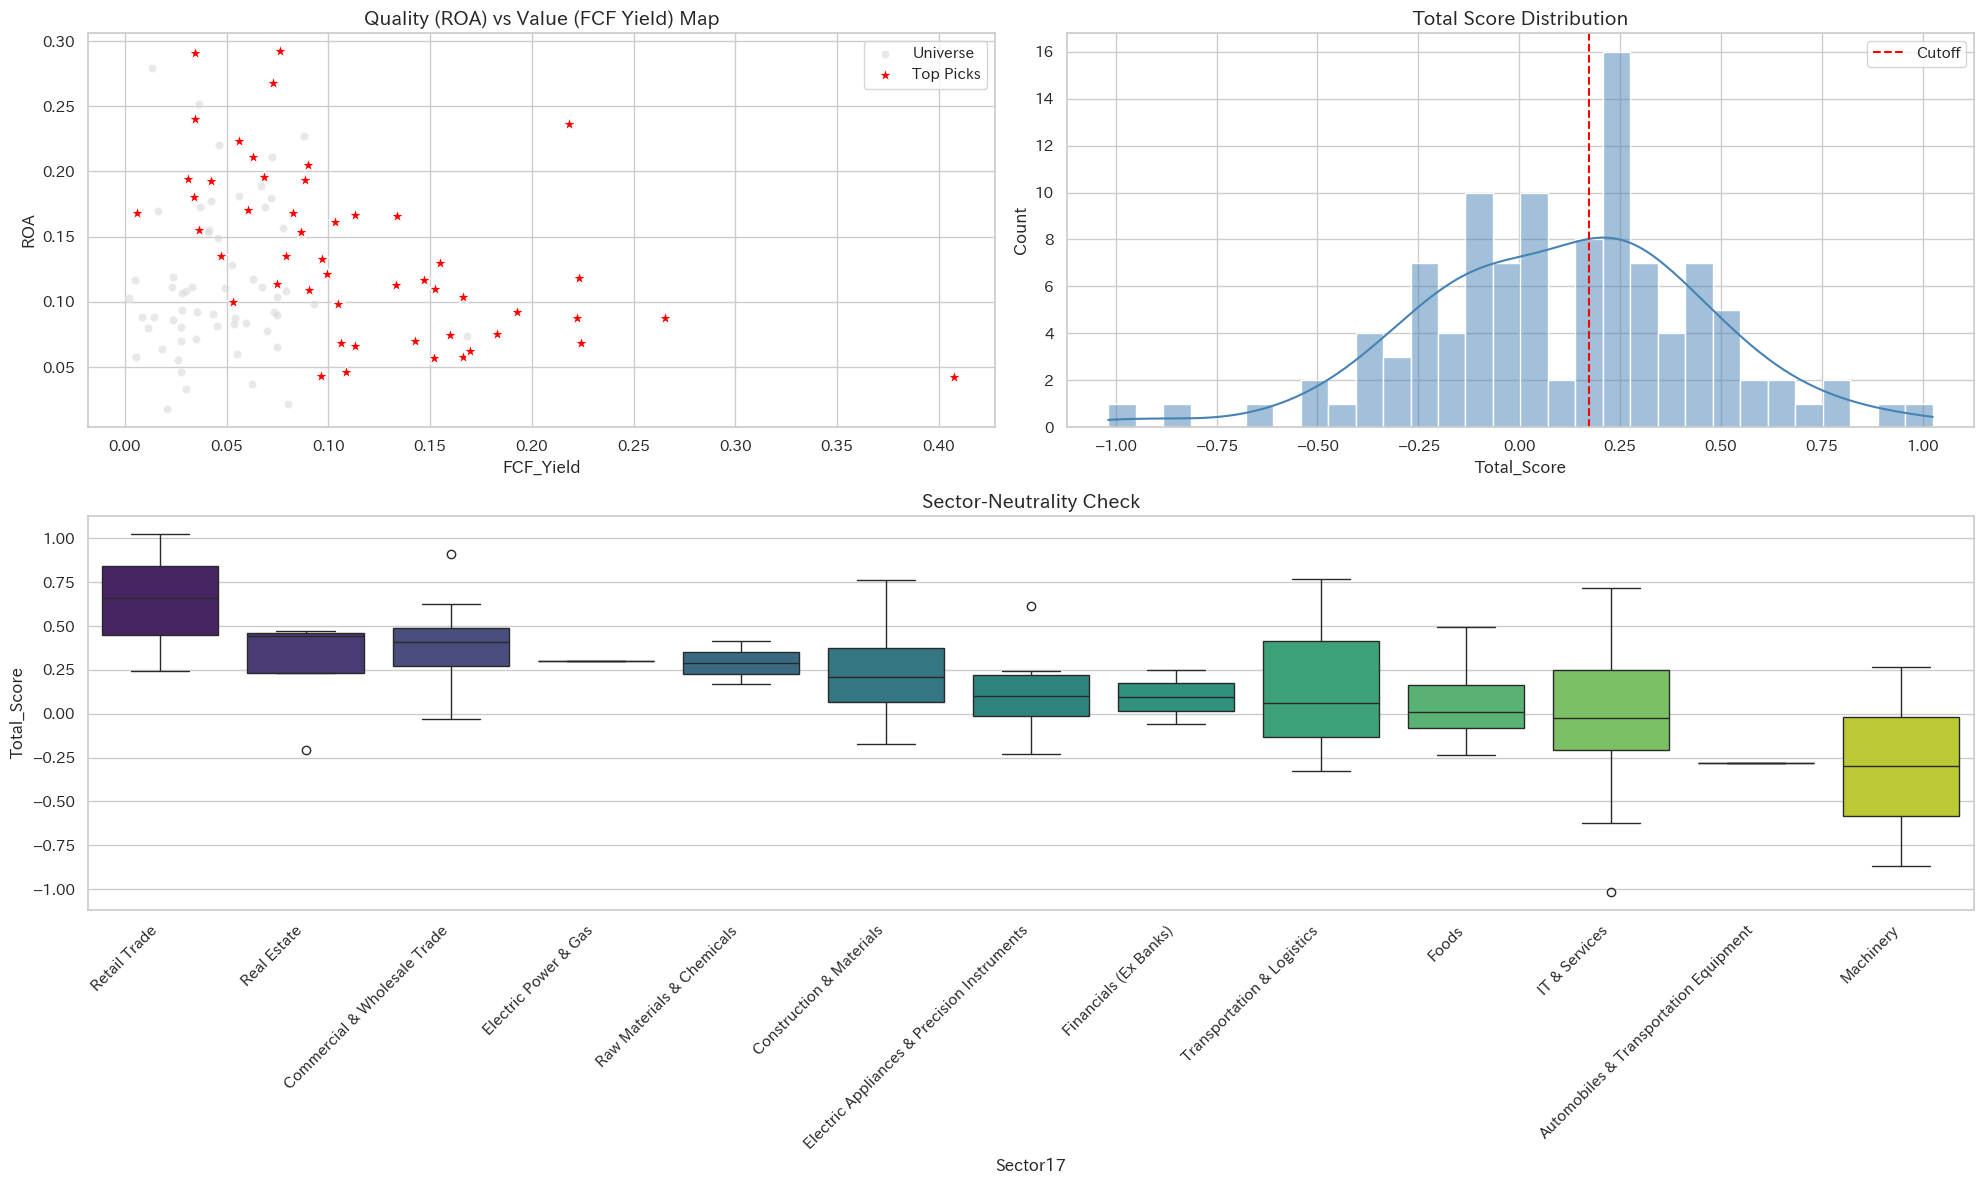

In [7]:
# =============================================================================
# [Cell 7] ライブスクリーニング実行 (Live Execution)
# =============================================================================

# 本日の日付で最新データを取得・分析し、推奨銘柄を表示します。
# バックテストと同じEngineインスタンスを使用しますが、モードが切り替わります。
if 'engine' in locals():
    engine.run_live_screening(top_n=50)
else:
    print("Please run the initialization cell (Cell 5) first to setup the engine.")